# Работа с временными рядами

In [28]:
import numpy as np
import pandas as pd


# metric
from sklearn.metrics import mean_squared_error

# graphs
import seaborn as sns
import pylab as plt
import plotly.graph_objects as go

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)


## 1. Скачаем данные

Загрузим датасет про ежемесячные продажи антидиабетических препаратов в Австралии с 1992 по 2008 год.

In [29]:
title = 'Monthly anti-diabetic drug sales in Australia from 1992 to 2008' 
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'])

df.index = df['date']
df = df.drop(columns=['date'])
df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


Сделаем из датасета объект типа `pd.Series` для более удобной работы в дальнейшем.

In [30]:
series = df.copy()
series = series['value']

Изобразим ряд на графике.

<Axes: xlabel='date'>

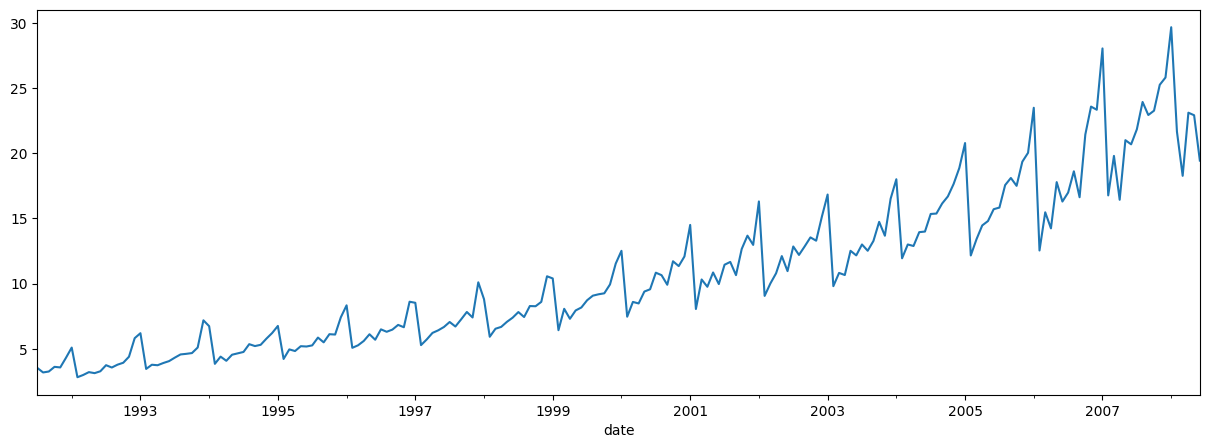

In [31]:
plt.figure(figsize=(15, 5))
series.plot()

## 2. Анализ ряда
### 2.1 Автокорреляция

Графики автокорреляционной функции (ACF).

<a href="http://www.statsmodels.org/dev/generated/statsmodel_holt1s.graphics.tsaplots.plot_acf.html">`statsmodels.graphics.tsaplots.plot_acf`</a>`(x, ax=None, lags=None, alpha=0.05, use_vlines=True, unbiased=False, fft=False, title='Autocorrelation', zero=True, **kwargs)`

* `x` &mdash; временной ряд;
* `lags` &mdash; набор лагов в виде списка или число (используется `np.arange(lags)`) &mdash; количество лагов, для которых мы считаем корреляцию;
* `ax` &mdash; фигура `matplotlib`;
* `alpha` &mdash; уровень доверия для доверительных интервалов.

На графиках по горизонтальной оси изображены лаги. Синими точками отмечены значения функций, для наглядности рисуется также отрезок, соединяющий их с горизонтальной осью. Закрашенная область соответствует области незначимой корреляции. Все значения, лежащие вне закрашенной области признаются значимо отличными от нуля.

Не забываем также, что в нуле значение всегда равно 1 &mdash; корреляция случайной величины с самой собой.

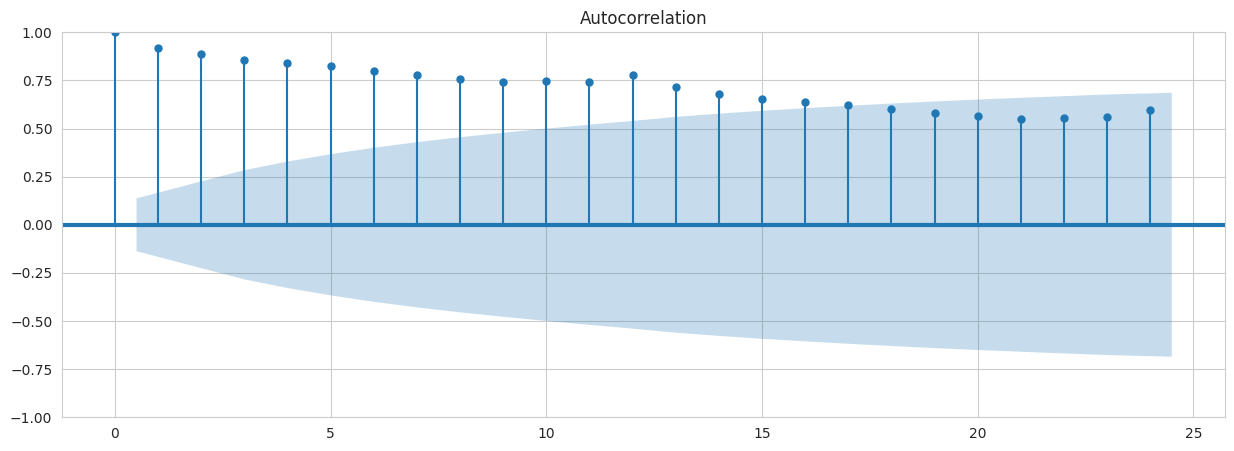

In [32]:
import statsmodels.graphics.tsaplots as sgt

with sns.axes_style('whitegrid'):
    sgt.plot_acf(series, lw=3)

### 2.2 Декомпозиция ряда

 <a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html">`statsmodels.tsa.seasonal.seasonal_decompose`</a>`(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)`

* `x` &mdash; временной ряд;
* `model` &mdash; `"additive", "multiplicative"`;
* `period` &mdash; период сезонности;
* `two_sided` &mdash; центрированное скользящее среднее или скользящее среднее по предыдущим значениям.

---

Сделаем мультипликативную декомпозицию нашего ряда

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

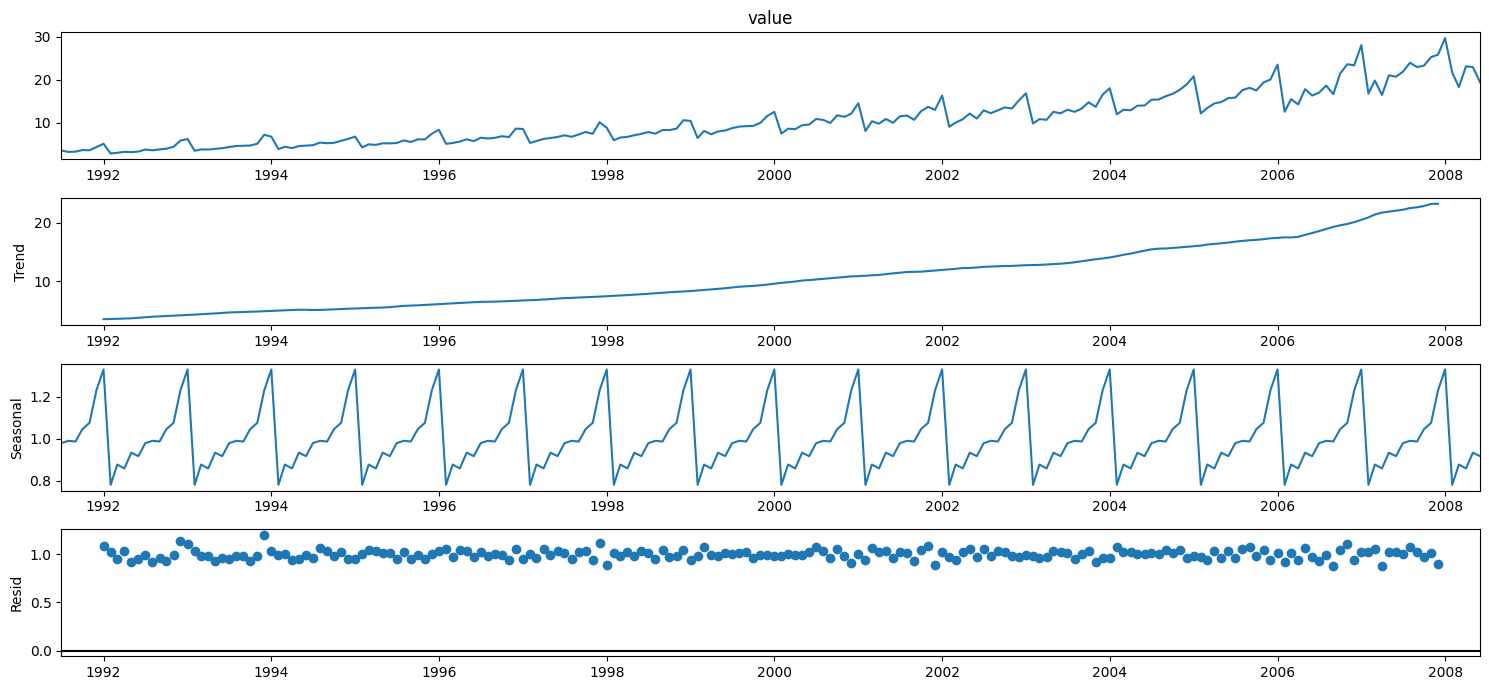

In [34]:
plt.rcParams['figure.figsize'] = [15, 7]

simple_result = seasonal_decompose(series, model='multiplicative', period=12)
_ = simple_result.plot()

----

STL-декомпозиция ряда.

<a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html?highlight=stl#statsmodels.tsa.seasonal.STL">`class statsmodels.tsa.seasonal.STL`</a>`(endog, period=None, seasonal=7, trend=None, low_pass=None, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=False, seasonal_jump=1, trend_jump=1, low_pass_jump=1)`

* `endog` &mdash; временной ряд;
* `period` &mdash; период сезонности;
* `robust` &mdash; использовать ли робастные веса в моделях, чтобы не обучаться на выбросы.

---

Сделаем STL-декомпозицию нашего ряда

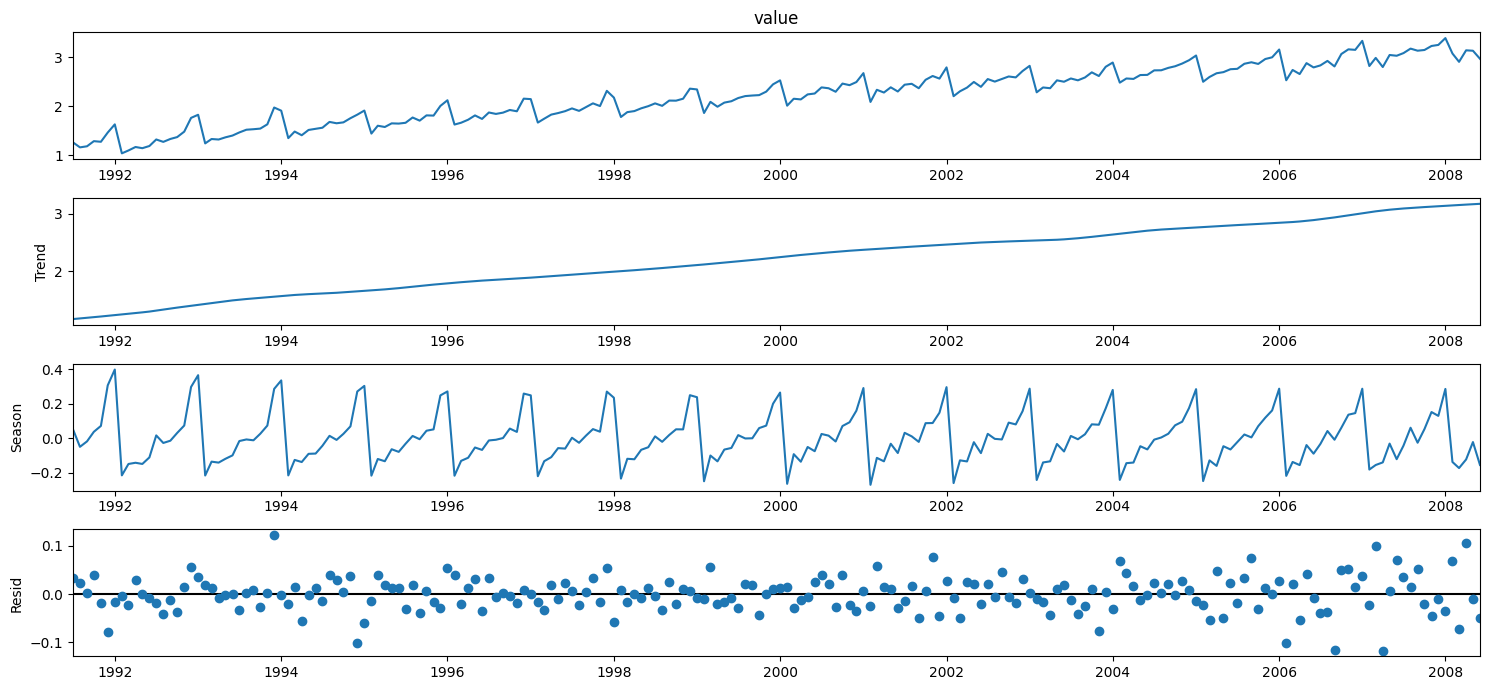

In [35]:
result = STL(np.log(series), period=12).fit()
_ = result.plot()

Сравним ошибки моделей:

In [36]:
np.exp(result.resid).mean(), simple_result.resid.mean()

(1.0008197641668466, 0.9994453786453805)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



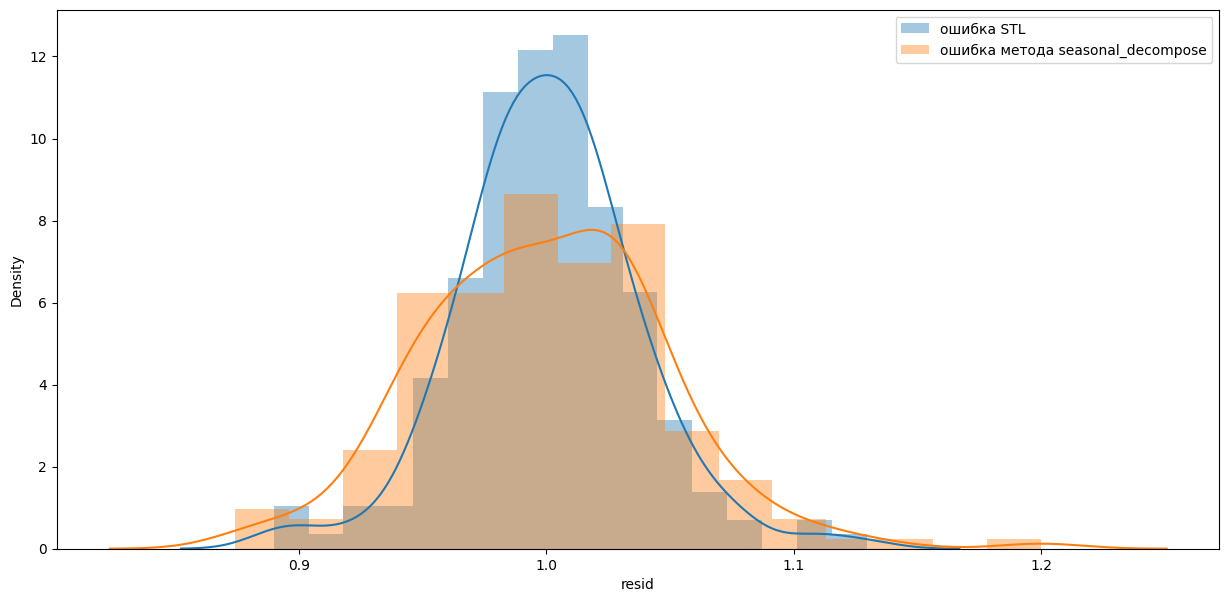

In [37]:
sns.distplot(np.exp(result.resid), label='ошибка STL')
sns.distplot(simple_result.resid, label='ошибка метода seasonal_decompose')

plt.legend()

## 3. Предиктивные модели

Зададим частоту временных данных

In [38]:
# series.index = pd.DatetimeIndex(series.index.values,
#                                freq=series.index.inferred_freq)

Будем предсказывать значения начиначиная с 2007 года.

In [39]:
train_data = series[series.index < pd.to_datetime('2007-01-01')]
predict_data = series[series.index >= pd.to_datetime('2007-01-01')]

Даты начала и окончания прогнозирования

In [40]:
start = predict_data.index.min()
end = predict_data.index.max()

Визуализируем на интерактивном графике обучение и тестовую часть

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=list(train_data), 
                         mode='lines', name='обучение'))
fig.add_trace(go.Scatter(x=predict_data.index, y=list(predict_data), 
                         mode='lines', name='будущее'))
fig.show()

### 3.1 Экспоненциальное сглаживание

<a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html?highlight=simpleexpsmoothing#statsmodels.tsa.holtwinters.SimpleExpSmoothing">`statsmodels.tsa.holtwinters.SimpleExpSmoothing`</a>`(endog, initialization_method=None, initial_level=None)`

- `endog` &mdash; временной ряд.

Прогноз взвешенным средним с экспоненциально убывающими весами.

$\hat{y}_{T+1|t} = \alpha y_T + (1-\alpha) \hat{y}_{T|T-1}$

---

Обучим модель с разными параметрами

In [42]:
# при smoothing_level = 0 предсказываем средним
# при smoothing_level = 1 предсказываем константой

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

fit1 = SimpleExpSmoothing(train_data, initialization_method="heuristic")\
    .fit(smoothing_level=0.2, optimized=False)  

fit2 = SimpleExpSmoothing(train_data, initialization_method="heuristic")\
    .fit(smoothing_level=0.6, optimized=False)

fit3 = SimpleExpSmoothing(train_data, initialization_method="estimated").fit()

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Сделаем прогнозы

In [43]:
fcast1 = fit1.predict(start=start, end=end)
fcast2 = fit2.predict(start=start, end=end)
fcast3 = fit3.predict(start=start, end=end)

Cоздание таблички с результатами и параметрами модели

In [44]:
fit3.sse

573.1945396342234

In [45]:
fit_models = [fit1, fit2, fit3]

fcast = [fit1.predict(start=start, end=end), 
         fit2.predict(start=start, end=end), 
         fit3.predict(start=start, end=end)]

last_alpha = round(fit3.model.params['smoothing_level'], 2)
labels = ['alpha=0.2', 'alpha=0.6', f'alpha={last_alpha}']

In [46]:
params = ['smoothing_level', ]
results=pd.DataFrame(index=["alpha", "SSE", "test MSE"],
                     columns=labels)

# SSE - sum of squared errors
# l_0 - начальное значение, 
for index in [1, 2, 3]:
    results[labels[index - 1]] = [fit_models[index - 1].params[p] for p in params] +\
                                 [fit_models[index-1].sse] +\
                                 [mean_squared_error(predict_data, fcast[index-1])]
results

,alpha=0.2,alpha=0.6,alpha=0.44
alpha,0.200000,0.600000,0.442150
SSE,591.638282,581.097293,573.194540
test MSE,17.464731,12.190649,11.935061


In [47]:
fit_models[2].summary()

Dep. Variable:,value,No. Observations:,186
Model:,SimpleExpSmoothing,SSE,573.195
Optimized:,True,AIC,213.339
Trend:,None,BIC,219.790
Seasonal:,None,AICC,213.560
Seasonal Periods:,None,Date:,"Wed, 31 Jan 2024"
Box-Cox:,False,Time:,16:23:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4421496,alpha,True
initial_level,3.4423730,l.0,True


Визуализируем результаты

In [54]:
# make gpraph bigger in size
fig = go.Figure(layout=go.Layout(
        height=600,
        width=1400
    ))
fig.add_trace(go.Scatter(x=train_data.index, y=list(train_data), 
                         mode='lines', name='обучение'))

fig.add_trace(go.Scatter(x=predict_data.index, y=list(predict_data), 
                         mode='lines', name='будущее'))


# plot predictions
for index in [1, 2, 3]:
    on_test = fcast[index - 1]

    fig.add_trace(go.Scatter(
        x=on_test.index, y=list(on_test),
        mode='lines', name= 'test' + ": " + labels[index - 1]
    ))


fig.show()


In [50]:
# # make gpraph bigger in size
# fig = go.Figure(layout=go.Layout(
#         height=600,
#         width=1400
#     ))
# fig.add_trace(go.Scatter(x=train_data.index, y=list(train_data), 
#                          mode='lines', name='обучение'))

# fig.add_trace(go.Scatter(x=predict_data.index, y=list(predict_data), 
#                          mode='lines', name='будущее'))


# # plot predictions
# for index in [1, 2, 3]:
#     on_train = fit_models[index - 1].fittedvalues
#     on_test = fcast[index - 1]

#     for dataset, dataset_str in zip([on_train, on_test], ['on_train', 'on_test']):

#         fig.add_trace(go.Scatter(
#             x=dataset.index, y=list(dataset), line=dict(color=colors[index-1]),
#             mode='lines', name= dataset_str + ": " + labels[index - 1]
#         ))


# fig.show()

# # todo: сделать график по-больше

## HOLT

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(train_data, 
                                trend='add', 
                                damped_trend=False, 
                                seasonal='mul',
                                use_boxcox=True,
                                seasonal_periods=12)
model_hw_fit = model_hw.fit()

forecast = model_hw_fit.forecast(steps=len(predict_data))

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [ ]:
model_hw_fit.params

{'smoothing_level': 0.10775682394886384,
 'smoothing_trend': 3.9873963921763957e-17,
 'smoothing_seasonal': 0.599897100048169,
 'damping_trend': nan,
 'initial_level': 1.2822811744497018,
 'initial_trend': 0.011204565091699838,
 'initial_seasons': array([1.01526839, 0.95721528, 0.96748989, 1.02350565, 1.03996463,
        1.21313569, 1.3002355 , 0.83610397, 0.88353312, 0.89396116,
        0.89168057, 0.90327124]),
 'use_boxcox': True,
 'lamda': 0.1079564307797949,
 'remove_bias': False}

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=list(train_data), 
                         mode='lines', name='обучение'))
fig.add_trace(go.Scatter(x=predict_data.index, y=list(predict_data), 
                         mode='lines', name='будущее'))

fig.add_trace(go.Scatter(x=forecast.index, y=list(forecast), 
                            mode='lines', name='Holt'))

fig.show()

In [ ]:
# todo: добавить подсчет метрики в этом; либо просто пролитстаь и сранивать с верхней таблицей

mean_squared_error(predict_data, forecast), model_hw_fit.sse

(7.0394247780545, 83.89036441635379)

In [ ]:
# таблица для сравнения
results

,alpha=0.2,alpha=0.6,alpha=0.44
alpha,0.200000,0.600000,0.442150
SSE,591.638282,581.097293,573.194540
test MSE,17.464731,12.190649,11.935061
